# Whiskey centroids with Apache Wayang

This example examines 86 Scotch whiskies that have been rated on
a five-point scale for 12 flavor characteristics: Body, sweetness, smoky, medicinal, tobacco, honey, spicy, winey, nutty, malty, fruity, and floral.
This data set comes from a book on the classification of Scotch whisky based on
flavors by David Wishart (2002) and can be found [online](https://www.niss.org/sites/default/files/ScotchWhisky01.txt).

In [1]:
%%classpath add mvn
org.apache.wayang wayang-api-scala-java_2.12 0.6.0
org.apache.wayang wayang-java 0.6.0
org.knowm.xchart xchart 3.8.3
org.apache.hadoop hadoop-common 3.3.3
org.scala-lang scala-library 2.12.15

Let's add some imports:

In [2]:
%import java.awt.Color
%import groovy.transform.TupleConstructor
%import org.apache.wayang.core.api.Configuration
%import org.apache.wayang.core.api.WayangContext
%import org.apache.wayang.core.function.ExecutionContext
%import org.apache.wayang.java.Java
%import org.apache.wayang.api.JavaPlanBuilder
%import org.knowm.xchart.*
%import static java.lang.Math.sqrt

Next we'll define `Point` and `TaggedPointCounter` classes:

In [3]:
class Point { double[] pts }

@TupleConstructor(includeSuperProperties=true)
class TaggedPointCounter extends Point {
    int cluster
    long count
    TaggedPointCounter plus(TaggedPointCounter other) {
        new TaggedPointCounter((0..<pts.size()).collect{ pts[it] + other.pts[it] } as double[], cluster, count + other.count)
    }
    TaggedPointCounter average() {
        new TaggedPointCounter(pts.collect{ it/count } as double[], cluster, 0)
    }
}
OutputCell.HIDDEN

Now we'll define a `SelectNearestCentroid` class. In Wayang parlance, this is a UDF (User Defined Function). This is executed for each iteration to recalculate the new centroids using the existing ones.

In [4]:
import org.apache.wayang.core.function.FunctionDescriptor.ExtendedSerializableFunction

class SelectNearestCentroid implements ExtendedSerializableFunction<Point, TaggedPointCounter> {
    Iterable<TaggedPointCounter> centroids

    void open(ExecutionContext context) {
        centroids = context.getBroadcast("centroids")
    }

    TaggedPointCounter apply(Point p) {
        def minDistance = Double.POSITIVE_INFINITY
        def nearestCentroidId = -1
        for (c in centroids) {
            def distance = sqrt((0..<p.pts.size()).collect{ p.pts[it] - c.pts[it] }.sum{ it ** 2 })
            if (distance < minDistance) {
                minDistance = distance
                nearestCentroidId = c.cluster
            }
        }
        new TaggedPointCounter(p.pts, nearestCentroidId, 1)
    }
}
OutputCell.HIDDEN

Now for our script:

In [ ]:
int k = 5
int iterations = 20
def url = '../resources/whiskey.csv'
def lines = new File(url).readLines()[1..-1] // skip header
pointsData = lines.collect{ new Point(pts: it.split(",")[2..-1]*.toDouble()) }
distilleries = lines.collect{ it.split(",")[1] }
def dims = pointsData[0].pts.size()

def r = new Random()
double[][] initPts = (1..k).collect{ (0..<dims).collect{ r.nextGaussian() + 2 } }

def config = new Configuration()
def context = new WayangContext(config).withPlugin(Java.basicPlugin())

def planBuilder = new JavaPlanBuilder(context, "KMeans ($url, k=$k, iterations=$iterations)")

def points = planBuilder
    .loadCollection(pointsData)

def initialCentroids = planBuilder
    .loadCollection((0..<k).collect{new TaggedPointCounter(initPts[it], it, 0)})
    .withName("Load random centroids")

finalCentroids = initialCentroids.repeat(iterations, { currentCentroids ->
    points.map(new SelectNearestCentroid())
        .withBroadcast(currentCentroids, "centroids").withName("Find nearest centroid")
        .reduceByKey({ tpc -> tpc.cluster }, { tpc1, tpc2 -> tpc1.plus(tpc2) }).withName("Add up points")
        .map({ tpc -> tpc.average() }).withName("Average points").withOutputClass(TaggedPointCounter)
}).withName("Loop").collect()

cols = ["Body", "Sweetness", "Smoky", "Medicinal", "Tobacco", "Honey",
        "Spicy", "Winey", "Nutty", "Malty", "Fruity", "Floral"]
println "Centroid: ${cols.collect{ (it + ' ')[0..4] }.join(', ')}"
finalCentroids.each { c ->
    println "Cluster$c.cluster: ${c.pts.collect{ sprintf('%.3f', it) }.join(', ')}"
}
OutputCell.HIDDEN

Centroid: Body , Sweet, Smoky, Medic, Tobac, Honey, Spicy, Winey, Nutty, Malty, Fruit, Flora
Cluster0: 2.941, 2.412, 1.588, 0.059, 0.000, 1.941, 1.706, 2.235, 2.000, 2.059, 2.235, 1.588
Cluster1: 2.909, 1.545, 2.909, 2.727, 0.455, 0.455, 1.455, 0.545, 1.545, 1.455, 1.182, 0.545
Cluster2: 1.696, 2.217, 1.565, 0.348, 0.130, 1.652, 1.870, 0.783, 1.087, 1.870, 1.739, 2.174
Cluster3: 1.529, 2.000, 0.941, 0.118, 0.000, 1.294, 0.588, 0.647, 1.941, 2.000, 1.941, 1.824
Cluster4: 1.722, 3.000, 1.167, 0.333, 0.111, 0.500, 1.167, 0.611, 0.944, 1.500, 1.722, 1.778


Let's look at the cluster assignments:

In [ ]:
def allocator = new SelectNearestCentroid(centroids: finalCentroids)
pointsData.withIndex().collect{ pt, idx ->
    [allocator.apply(pt).cluster, distilleries[idx]]
}.groupBy{ cluster, dist -> cluster }.collectEntries{ k, v -> [k, v.collect{ it[1] }] }

And finally a spider plot of our centroid characteristics:

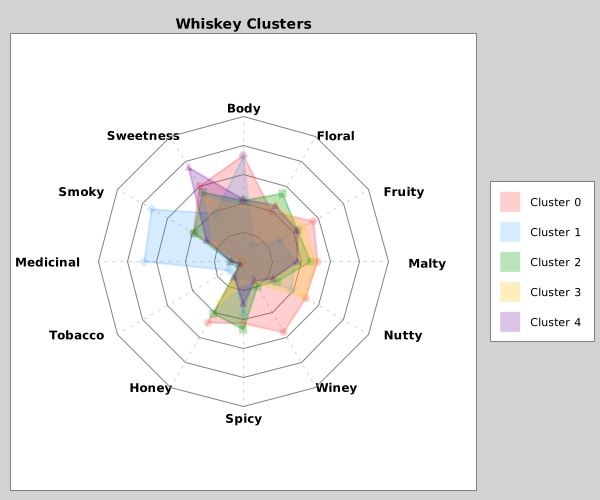

In [ ]:
RadarChart chart = new RadarChartBuilder().width(600).height(500).title('Whiskey Clusters').build()
chart.variableLabels = cols as String[]
chart.styler.with {
    legendVisible = true
    seriesColors = [new Color(255, 51, 51, 60),
                    new Color(51, 153, 255, 50),
                    new Color(0, 153, 0, 70),
                    new Color(255, 204, 51, 80),
                    new Color(102, 0, 153, 60)] as Color[]
}

finalCentroids.each { c ->
    chart.addSeries("Cluster $c.cluster", c.pts.collect{ it/4 } as double[])
}

BitmapEncoder.getBufferedImage(chart)